## Base Code

### Part 1: Import Necessary Modules

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import shap
import os
from ipywidgets import interact, IntSlider

print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.13.0
GPU is NOT AVAILABLE


### Part 2: Data Preparation

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 5s 0us/step


### Part 3: Model Definition

In [5]:
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

### Part 4: Model Loading or Training

In [6]:
model_path = 'cifar10_cnn.keras'
if os.path.exists(model_path):
    print("Loading pre-trained model...")
    model = tf.keras.models.load_model(model_path)
else:
    print("No pre-trained model found. Training a new model...")
    model = create_model()
    history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))
    model.save(model_path)
    print(f"Model saved to {model_path}")

No pre-trained model found. Training a new model...
Epoch 1/10
1563/1563 [==============================] - 18s 11ms/step - loss: 1.5174 - accuracy: 0.4437 - val_loss: 1.3275 - val_accuracy: 0.5291
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.1595 - accuracy: 0.5871 - val_loss: 1.1212 - val_accuracy: 0.5991
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.0043 - accuracy: 0.6476 - val_loss: 0.9968 - val_accuracy: 0.6491
Epoch 4/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.9087 - accuracy: 0.6795 - val_loss: 0.9443 - val_accuracy: 0.6694
Epoch 5/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8333 - accuracy: 0.7079 - val_loss: 0.9446 - val_accuracy: 0.6760
Epoch 6/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.7732 - accuracy: 0.7285 - val_loss: 0.9059 - val_accuracy: 0.6929
Epoch 7/10
1563/1563 [==============================] - 17s 11ms/step - 

### Part 5: Model Evaluation

In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

313/313 - 1s - loss: 0.9346 - accuracy: 0.6901 - 1s/epoch - 4ms/step
Test accuracy: 0.69


Part 6: Model Testing

In [8]:
def test_model(model, test_images, test_labels, num_samples=5):
    indices = np.random.choice(test_images.shape[0], num_samples, replace=False)
    sample_images = test_images[indices]
    sample_labels = test_labels[indices]

    predictions = model.predict(sample_images)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(sample_images[i])
        predicted_class = class_names[np.argmax(predictions[i])]
        true_class = class_names[sample_labels[i][0]]
        ax.set_title(f"Pred: {predicted_class}\nTrue: {true_class}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## SHAP Preparation

In [11]:
# Initialize SHAP explainer for the Keras model
explainer = shap.DeepExplainer(model, train_images[:100])  # Use a small subset for the background

def shap_visualization(image_index):
    image = test_images[image_index:image_index+1]
    true_label = test_labels[image_index][0]

    # Generate and process SHAP values
    shap_values = explainer.shap_values(image)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    shap_values_for_class = shap_values[0, ..., predicted_class]
    shap_sum = np.sum(shap_values_for_class, axis=-1)

    # Normalize SHAP values for scatter plot
    shap_normalized = (shap_sum - shap_sum.min()) / (shap_sum.max() - shap_sum.min())

    # Create figure with subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Original Image
    axs[0].imshow(image[0])
    axs[0].set_title("Original Image\nTrue: " + class_names[true_label])
    axs[0].axis('off')

    # Scatter Plot with Stars on Image
    y, x = np.indices(shap_sum.shape)
    colors = shap_sum.flatten()  # Color by SHAP values
    sizes = 100 * shap_normalized.flatten() + 10  # Size of stars
    axs[1].imshow(image[0], aspect='auto')  # Display the original image as background
    scatter = axs[1].scatter(x.flatten(), y.flatten(), c=colors, s=sizes, cmap='coolwarm', marker='o', alpha=0.6)
    axs[1].set_title("SHAP Scatter on Image\nPredicted: " + class_names[predicted_class])
    axs[1].axis('off')
    fig.colorbar(scatter, ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

c:\Users\Jun\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


### Test the Function

c:\Users\Jun\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


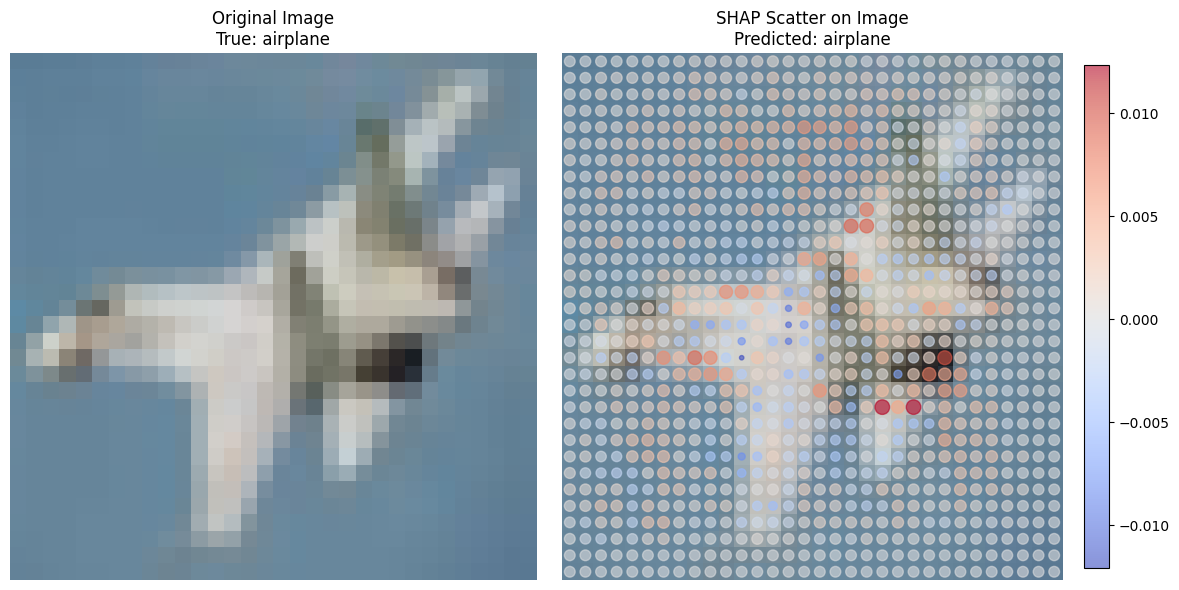

In [12]:
# Test the function
shap_visualization(10)  # Visualize SHAP values for the 11th image